In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from tabulate import tabulate
import os, os.path as path

from spectrum import FitsSpectrum
from common import list_files, list_directories, tqdm

In [5]:
dib_centers_all = np.loadtxt('data/dibs_list.csv')
dib_centers_subset = [5780,5797,6196,6379,6613,7224]

def load_target(target_dir: str) -> list[FitsSpectrum]:
    return [FitsSpectrum(datafile) for band_dir in list_directories(target_dir) for datafile in list_files(band_dir)]

def fit_gaussian_for_subspectrum(
    subspectrum: FitsSpectrum,
    create_figure = False,
    export_data: list | None = None,
    table_data: list | None = None,
    dib_slice: tuple[int, int] | None = None,
    expected_dib_centers: np.typing.NDArray | None = None,
    tqdm_position: int = 0,
    show_error = False,
    save_plot = None
):
    wvl_max, wvl_min = np.max(subspectrum.wavelength), np.min(subspectrum.wavelength)

    subspectrum.remove_outliers()
    subspectrum.correct_shift()

    dibs = list(subspectrum.select_dibs().items())
    dibs_tqdm = tqdm(dibs if dib_slice is None else dibs[dib_slice[0]:dib_slice[1]], position=tqdm_position)
    for center, bounds in dibs_tqdm:
        dibs_tqdm.set_description(f'λ={wvl_min:.2f}-{wvl_max:.2f} [{center:.2f}]')

        # The DIB does not lie in this subspectrum or is not an expected DIB (within 2 angstrom)
        if not wvl_min < center < wvl_max or (expected_dib_centers is not None and np.all(np.abs(expected_dib_centers - center) > 0.5)):
            continue

        fig, ax = None, None
        if create_figure:
            fig, ax = plt.subplots(1, 1, figsize=(15, 12))

        result = subspectrum.fit_gaussian(center, bounds, ax=ax, show_error=show_error)

        if result is None:
            continue

        if save_plot is not None:
            fig.savefig(f'export/{save_plot}')

        params, rmse, fwhm, ew = result
        centers, widths, amplitudes, skews = np.column_stack(params)

        if table_data is not None:
            table_data.append([subspectrum.target, subspectrum.format_obs_date(), bounds[0], bounds[1], *np.column_stack(params), rmse, fwhm, ew])

        if export_data is not None:
            export_data.append('\t'.join([
                subspectrum.obs_date.isoformat(),
                str(bounds[0]), str(bounds[1]),
                np.array2string(centers, separator=','),
                np.array2string(amplitudes, separator=','),
                np.array2string(widths, separator=','),
                np.array2string(skews, separator=','),
                str(rmse), str(fwhm), str(ew)
            ]).replace('\n', ' ').replace('\r', ' ').strip())


def fit_gaussian_for_targets(
    targets: list | str,
    expected_dib_centers: np.typing.NDArray | None = None,
    export = False,
    create_figure = False,
    show_error = False
):
    headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'FWHM [Å]', 'EW [Å]']
    table_data = []

    if type(targets) == str:
        targets = [targets]

    targets_tqdm = tqdm(targets)
    for target in targets_tqdm:
        export_data = ['# ' + '\t'.join(headers)] if export else None
        subspectra = load_target(f'data/fits/{target}')
        
        for subspectrum in subspectra:
            targets_tqdm.set_description(f'{subspectrum.target} | {subspectrum.format_obs_date()}')
            fit_gaussian_for_subspectrum(subspectrum, create_figure, export_data, table_data, expected_dib_centers=expected_dib_centers, tqdm_position=1, show_error=show_error)

        if export:
            export_file = open(f'export/{target}_gaussians.csv', 'w+')
            export_file.write('\n'.join(export_data))
            export_file.close()

    return tabulate(table_data, ['Target', *headers], tablefmt='html')


In [ ]:
hd185859 = load_target('data/fits/HD185859')

sp = hd185859[1]
_ = fit_gaussian_for_subspectrum(hd185859[1], True, dib_slice=(40, 50))
# _ = fit_gaussian_for_subspectrum(hd185859[1], True, expected_dib_centers=dib_centers_all)

λ=5654.46-6686.46 [6654.80]: 100%|██████████| 219/219 [00:02<00:00, 93.76it/s] 


'<table>\n<thead>\n<tr></tr>\n</thead>\n<tbody>\n</tbody>\n</table>'

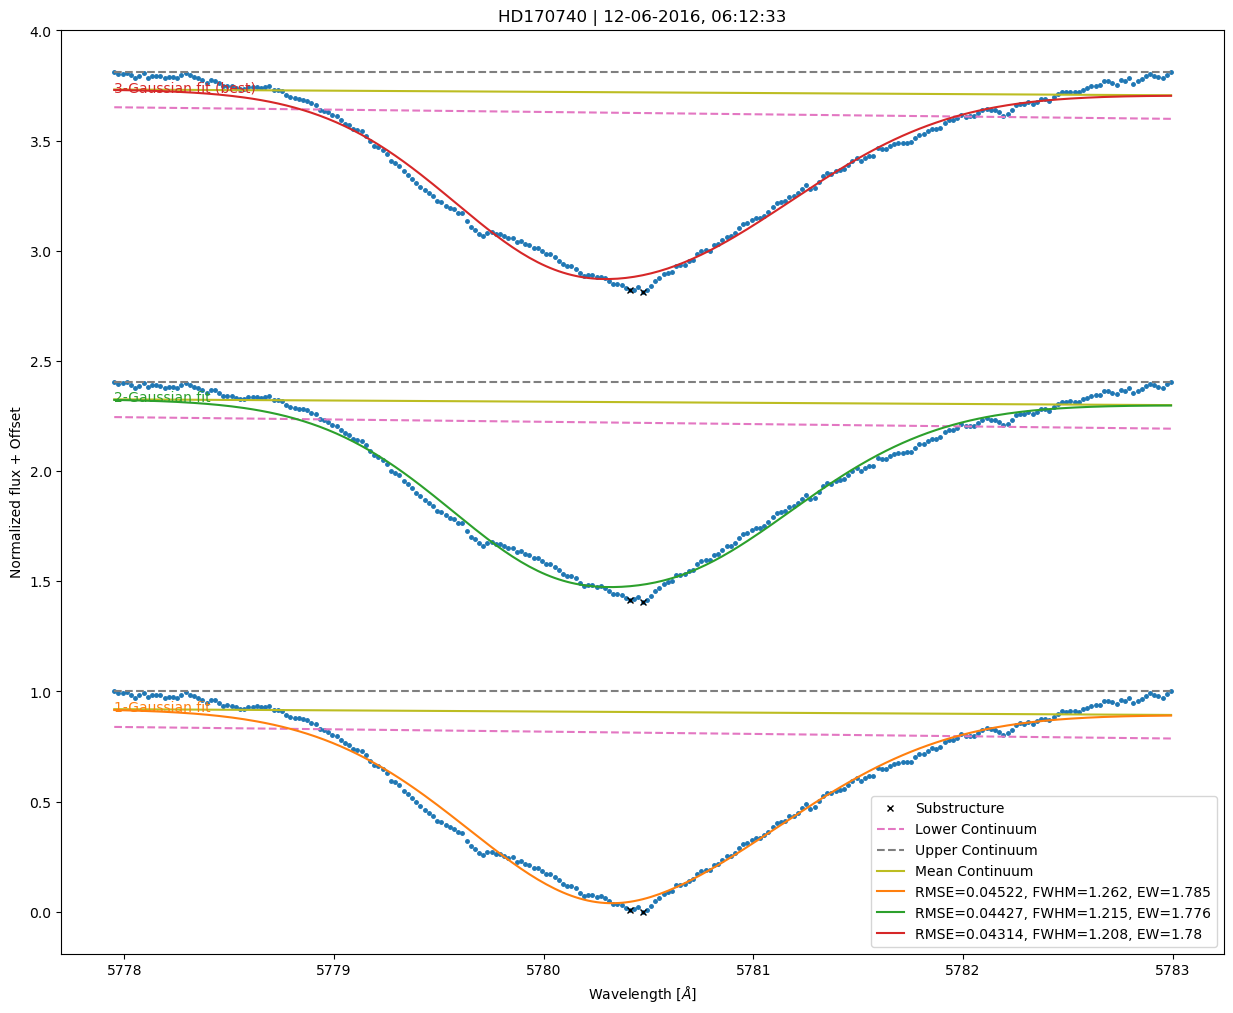

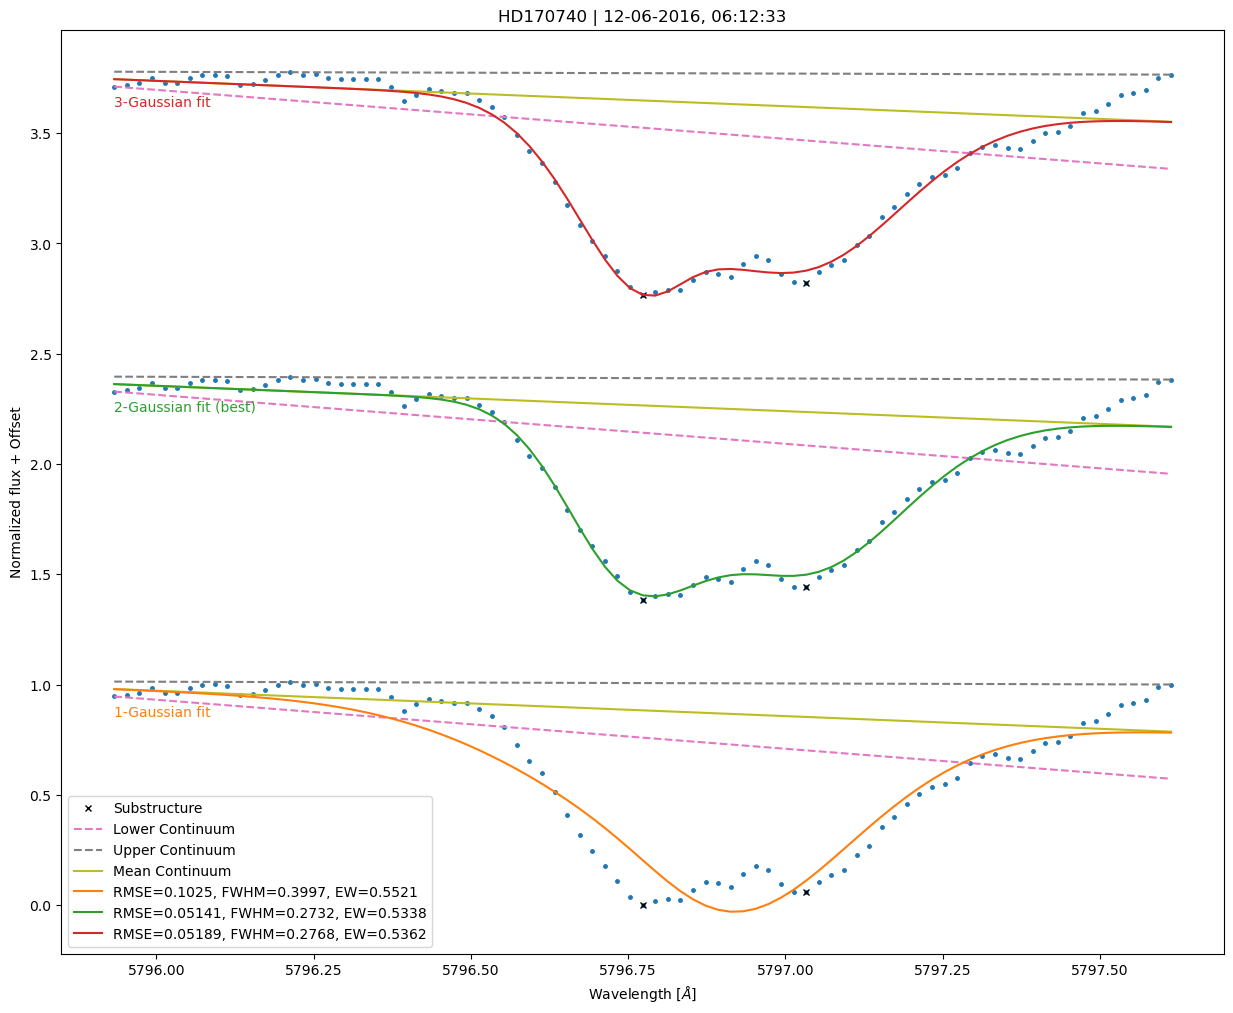

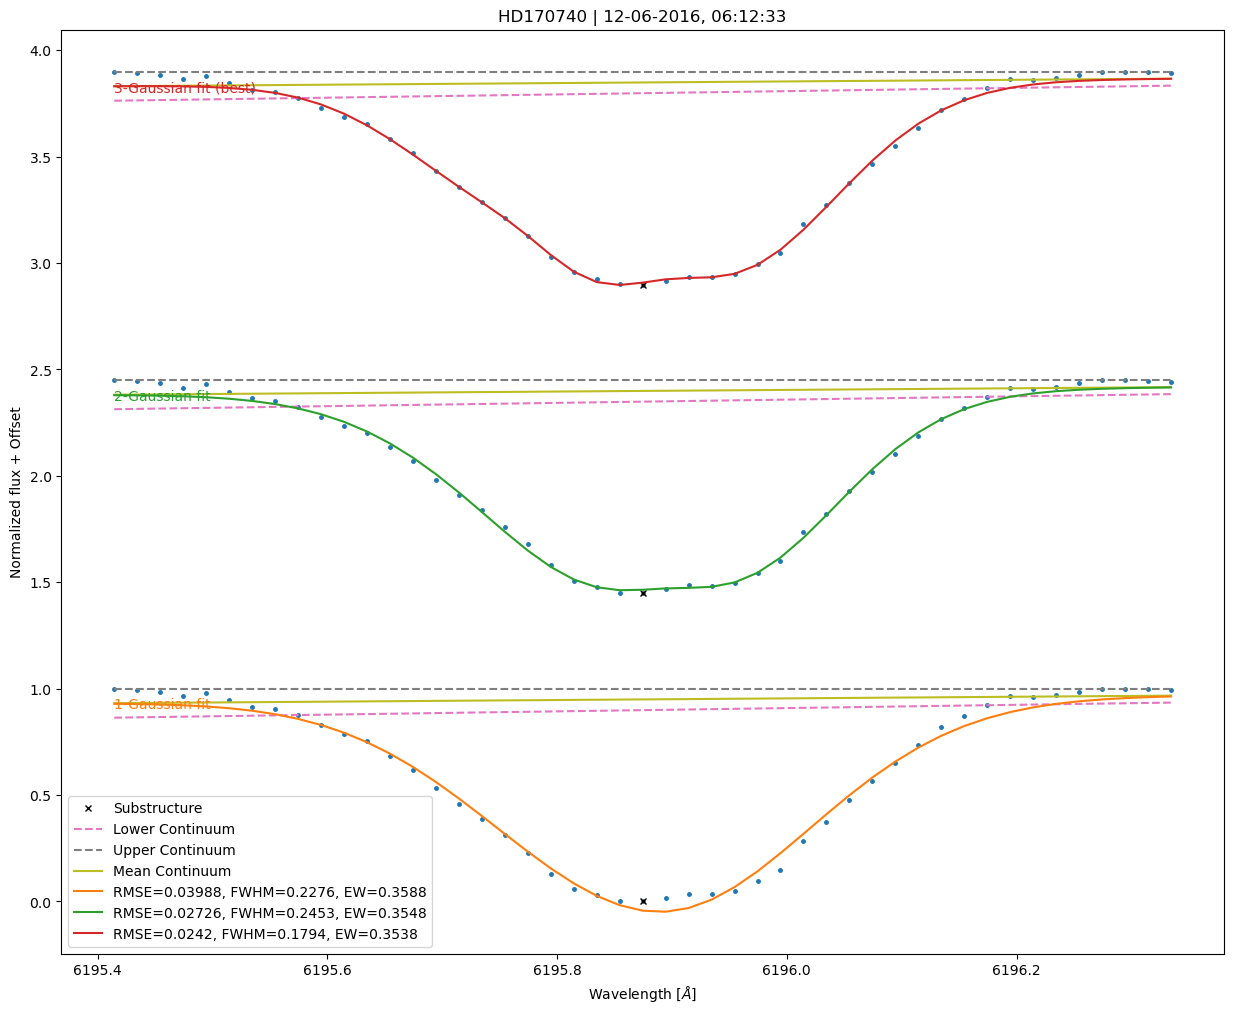

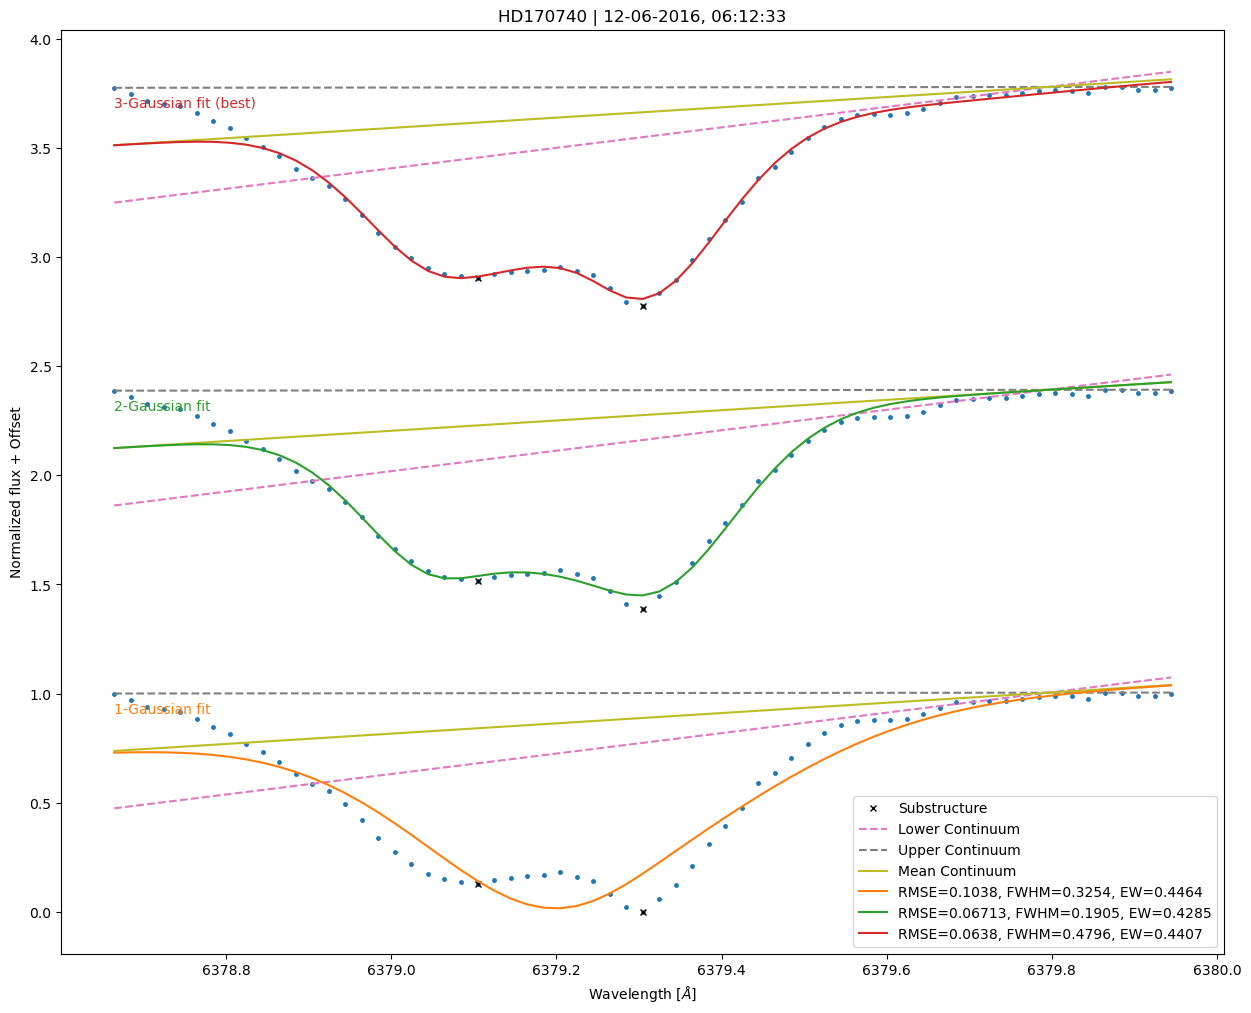

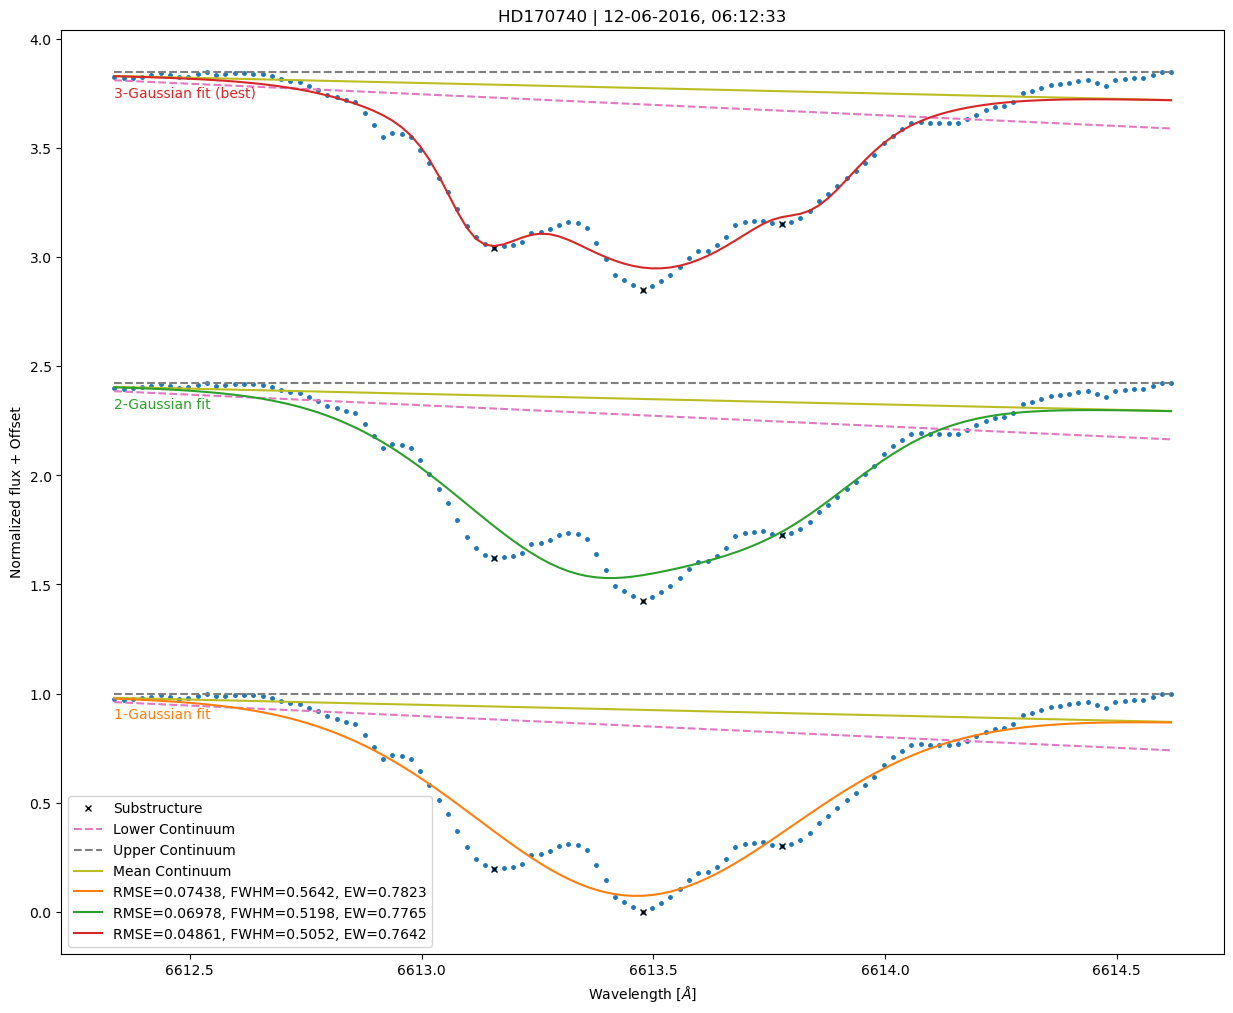

In [11]:
headers = ['Observation date', 'Start [Å]', 'End [Å]', 'Center [Å]', 'Width', 'Amplitude', 'Skew', 'RMSE', 'FWHM [Å]', 'EW [Å]']
table_data = []

fit_gaussian_for_subspectrum(
    FitsSpectrum('data/fits/HD170740/RED_564/HD170740_w564_n9_20160612_U.fits'),
    expected_dib_centers=dib_centers_subset,
    create_figure=True,
    # show_plot='',
    # table_data=table_data
    # show_error=True
)

tabulate(table_data, ['Target', *headers], tablefmt='html')

In [6]:
_ = fit_gaussian_for_targets('HD170740', expected_dib_centers=dib_centers_all, export=True)

  0%|          | 0/1 [00:00<?, ?it/s]

HD170740 | 05-05-2016, 04:55:55:   0%|          | 0/1 [00:00<?, ?it/s]

[WARNING]: Found 22 substructures around 5.7e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 9 substructures around 6e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.1e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 7 substructures around 6.1e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.2e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.2e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.2e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.4e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


λ=5654.48-6686.46 [6657.43]: 100%|██████████| 154/154 [00:08<00:00, 17.84it/s]
HD170740 | 16-09-2014, 02:15:41:   0%|          | 0/1 [00:09<?, ?it/s]

[WARNING]: Found 6 substructures around 4.8e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 5.4e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


[WARNING]: Found 8 substructures around 5.5e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


λ=4582.90-5644.30 [5597.78]: 100%|██████████| 244/244 [00:02<00:00, 101.35it/s]
HD170740 | 12-06-2016, 06:12:33:   0%|          | 0/1 [00:11<?, ?it/s]

[WARNING]: Found 12 substructures around 5.7e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.2e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.2e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 17 substructures around 6.4e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


λ=5654.46-6686.46 [6654.80]: 100%|██████████| 219/219 [00:13<00:00, 15.73it/s]
HD170740 | 16-09-2014, 02:15:41:   0%|          | 0/1 [00:25<?, ?it/s]

[WARNING]: Found 29 substructures around 5.7e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 5.8e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


[WARNING]: Found 10 substructures around 5.8e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


[WARNING]: Found 7 substructures around 6.2e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


[WARNING]: Found 8 substructures around 6.4e+03 for HD170740 16-09-2014, 02:15:41, limiting to the 5 most prominent ones.


λ=5654.54-6686.72 [6650.14]: 100%|██████████| 268/268 [00:04<00:00, 61.53it/s]
HD170740 | 24-04-2015, 09:19:05:   0%|          | 0/1 [00:30<?, ?it/s]

[WARNING]: Found 11 substructures around 4.7e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 19 substructures around 4.8e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 8 substructures around 4.8e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 18 substructures around 5.4e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 5.5e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 13 substructures around 5.5e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


λ=4583.02-5644.24 [5606.82]: 100%|██████████| 267/267 [00:06<00:00, 43.37it/s]
HD170740 | 05-05-2016, 04:55:55:   0%|          | 0/1 [00:36<?, ?it/s]

[WARNING]: Found 6 substructures around 4.7e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 16 substructures around 4.8e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 13 substructures around 4.8e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 10 substructures around 4.9e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 15 substructures around 5.4e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


[WARNING]: Found 8 substructures around 5.4e+03 for HD170740 05-05-2016, 04:55:55, limiting to the 5 most prominent ones.


λ=4583.08-5644.24 [5606.44]: 100%|██████████| 178/178 [00:03<00:00, 52.31it/s]
HD170740 | 12-06-2016, 06:12:33:   0%|          | 0/1 [00:40<?, ?it/s]

[WARNING]: Found 10 substructures around 4.7e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 7 substructures around 4.8e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 10 substructures around 4.8e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 8 substructures around 4.8e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 7 substructures around 5e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 18 substructures around 5.4e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


[WARNING]: Found 9 substructures around 5.5e+03 for HD170740 12-06-2016, 06:12:33, limiting to the 5 most prominent ones.


λ=4583.08-5644.24 [5606.30]: 100%|██████████| 247/247 [00:07<00:00, 32.57it/s]
HD170740 | 24-04-2015, 09:19:05:   0%|          | 0/1 [00:47<?, ?it/s]

[WARNING]: Found 19 substructures around 5.7e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 7 substructures around 6e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 6.2e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 7 substructures around 6.2e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 12 substructures around 6.4e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


[WARNING]: Found 9 substructures around 6.4e+03 for HD170740 24-04-2015, 09:19:05, limiting to the 5 most prominent ones.


λ=5654.50-6686.52 [6653.92]: 100%|██████████| 208/208 [00:13<00:00, 15.42it/s]
HD170740 | 01-07-2017, 04:34:34:   0%|          | 0/1 [01:01<?, ?it/s]

[WARNING]: Found 21 substructures around 5.7e+03 for HD170740 01-07-2017, 04:34:34, limiting to the 5 most prominent ones.


[WARNING]: Found 7 substructures around 5.7e+03 for HD170740 01-07-2017, 04:34:34, limiting to the 5 most prominent ones.


[WARNING]: Found 6 substructures around 5.8e+03 for HD170740 01-07-2017, 04:34:34, limiting to the 5 most prominent ones.


[WARNING]: Found 9 substructures around 5.8e+03 for HD170740 01-07-2017, 04:34:34, limiting to the 5 most prominent ones.


λ=5654.46-6686.48 [5784.89]:  12%|█▏        | 34/273 [00:05<00:37,  6.40it/s]
HD170740 | 01-07-2017, 04:34:34:   0%|          | 0/1 [01:06<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
_ = fit_gaussian_for_targets(['HD147889', 'HD158926', 'HD170740', 'HD185859'], expected_dib_centers=dib_centers_all, export=True)

In [ ]:
fit_gaussian_for_targets(os.listdir('data/fits'), filename='gaussian_fits_all.csv')